# Faithful dataset

In [18]:
import numpy as np

import requests
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import stats as scistats

import jax.numpy as jnp
from jax import random


In [19]:
# Implementation of a variational mixture of Gaussians
# Author: Gerardo Duran-Martin (@gerdm)

import jax
import jax.numpy as jnp
from jax.scipy import special
from jax.numpy.linalg import inv, det

# from jax.ops import index_update #deprecated
from sklearn.exceptions import NotFittedError
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions


class VBMixture:
    """
    Implementation of a variational mixture of Gaussians model using a standard mean
    field approximation to the posterior in the form
                            q(h) = q(θ) ∏n qn(z_n)
    Where θ are the model parameters of the mixture of Gaussians and zn are the
    latent variables.

    For more information see: Example: VBEM for a GMM
    """

    def __init__(self):
        self.fitted = False
        self.compute_responsibilities = jax.jit(self._compute_responsibilities)
        self.posterior_params = jax.jit(self._posterior_params)
        self.gmm_lower_bound = jax.jit(self._gmm_lower_bound)

    def _compute_e_log_pi(self, alpha):
        """
        Compute the expected value of every log pi_k, i.e.,
        compute ∀k. E[log pi_k]
        """
        return special.digamma(alpha) - special.digamma(alpha.sum())

    def _compute_e_log_lambda(self, X, eta, W):
        """
        Compute the expected value of every log det Lambda_k, i.e,
        compute ∀k. E[log|Lambda_k|]
        """
        _, M = X.shape
        return special.digamma((eta + 1 - M) / 2) + M * jnp.log(2) + det(W)

    def expected_values(self, hist=None):
        """
        Compute the expected values for the parameters
        π_k, μ_k and Λ_k of the re-estimation equations
        for the lower-bound.

        Parameters
        ----------
        hist: dictionary
            Entry of the list returned by the .fit method
            if store_hist=True

        Returns
        -------
        * array(K): weight of each cluster
        * array(K, M): center of each cluster
        * array(K, M, M): covariance matrix of each cluster
        """
        if not self.fitted and hist is None:
            raise NotFittedError("This VBMixture instance is not fitted yet.")
        elif hist is None:
            pi_k = self.alpha_k / self.alpha_k.sum()
            mu_k = self.m_k.T
            Sigma_k = inv(self.eta_k[:, None, None] * self.W_k)
        else:
            pi_k = hist["alpha"] / hist["alpha"].sum()
            mu_k = hist["m"].T
            Sigma_k = inv(hist["eta"][:, None, None] * hist["W"])

        return pi_k, mu_k, Sigma_k

    def _compute_m_statistics(self, X, r):
        # We add term to avoid division by zero
        Nk = r.sum(axis=0) + 1e-6
        xbar_k = (X[..., None] * r[:, None, :]).sum(axis=0) / Nk
        Sk = (X[..., None] - xbar_k)[..., None, :]
        Sk = jnp.einsum("il,ijkl,ikjl->kjl", r, Sk, Sk) / Nk

        return Nk, xbar_k, Sk

    def _compute_responsibilities(self, X, alpha, beta, eta, m, W):
        """
        Compute model responsibilities
        (Variational E-Step)
        """
        N, M = X.shape
        E_logpi = self._compute_e_log_pi(alpha)
        E_logLambda = self._compute_e_log_lambda(X, eta, W)
        diffk = X[:, None, :] - m.T
        mpart = jnp.einsum("ijk,jkk->ijk", diffk, W)
        E_mahal = eta * jnp.einsum("ijk,ijk->ij", mpart, diffk) + M / beta

        log_rho_nk = (
            E_logpi + E_logLambda / 2 - M / 2 * jnp.log(2 * jnp.pi) - E_mahal / 2
        )

        r = jax.nn.softmax(log_rho_nk)
        return r

    def _posterior_params(self, X, r, alpha, beta, eta, m, W):
        """
        Compute the posterior parameters for each
        components of the mixture of gaussians
        (Variational M-Step)
        """
        Nk, xbar_k, Sk = self._compute_m_statistics(X, r)
        alpha_k = alpha + Nk
        beta_k = beta + Nk
        eta_k = eta + Nk

        m_k = (beta * m + Nk * xbar_k) / beta_k
        C0 = (beta * Nk) / (beta + Nk)
        f0 = (xbar_k - m)[:, None, :]
        W_k_inv = (
            inv(W)
            + (Nk * Sk).T
            + C0[:, None, None] * jnp.einsum("ijk,jik->kij", f0, f0)
        )
        W_k = inv(W_k_inv)

        return alpha_k, beta_k, eta_k, m_k, W_k

    def compute_log_C(self, alpha):
        """
        Compute the log-transformation of the dirichlet
        normalization constant

        Parameters
        ----------
        alpha: np.array(K,)
            {αi}i components of a dirichlet

        Returns
        -------
        float: log(C(α)) = log Γ(Σi α_i) - Σi Γ(alpha_i)
        """
        return special.gammaln(alpha.sum()) - special.gammaln(alpha).sum()

    def E1(self, X, r, beta, eta, m, W):
        """
        E[log p(X|Z,μ,Λ)]
        """
        N, M = X.shape
        Nk, xbar_k, Sk = self._compute_m_statistics(X, r)
        log_hat_Λ = self._compute_e_log_lambda(X, eta, W)
        Tr_Sk_Wk = jnp.einsum("ijm,mji->m", Sk, W)
        diffk = xbar_k - m
        mahal_xbar = jnp.einsum("im,mij,jm->m", diffk, W, diffk)

        E_val = (
            Nk
            * (
                log_hat_Λ
                - M / beta
                - eta * Tr_Sk_Wk
                - eta * mahal_xbar
                - M * jnp.log(2 * jnp.pi)
            )
            / 2
        )

        return E_val.sum()

    def E2(self, r, alpha):
        """
        E[log p(Z|π)]
        """
        log_hat_π = self._compute_e_log_pi(alpha)
        E_val = jnp.einsum("ik,k->", r, log_hat_π)

        return E_val.sum()

    def E3(self, alpha, alpha_0):
        """
        E[log p(π)]
        """
        log_C_α0 = self.compute_log_C(alpha_0)
        log_hat_π = self._compute_e_log_pi(alpha)

        return log_C_α0 + (alpha_0[0] - 1) * log_hat_π.sum()

    def E4(self, X, beta, eta, m, W, beta_0, eta_0, m_0, W_0):
        """
        E[log p(μ, Λ)]
        """
        N, M = X.shape
        K, *_ = eta.shape
        decomp = jnp.linalg.cholesky(W_0)
        wishart = tfd.WishartTriL(df=eta_0, scale_tril=decomp)

        diffk = m - m_0
        log_hat_Λ = self._compute_e_log_lambda(X, eta, W)
        mahal_mk = jnp.einsum("im,mij,jm->m", diffk, W, diffk)
        Tr_W0inv_W = jnp.einsum("mij,mij->m", inv(W_0), W)

        term1 = (
            M * jnp.log(beta_0[0] / (jnp.pi * 2)).sum()
            + log_hat_Λ
            - M * beta_0 / beta
            - beta_0 * eta * mahal_mk
        ).sum() / 2
        term2 = K * wishart.log_normalization().sum()
        term3 = ((eta_0 - M - 1) / 2 * log_hat_Λ).sum()
        term4 = (eta * Tr_W0inv_W).sum() / 2

        E_val = term1 + term2 + term3 - term4

        return E_val

    def E5(self, r):
        """
        E[log q(Z)]
        """
        terms = r * jnp.log(r)
        return jnp.nansum(terms)

    def E6(self, alpha):
        """
        E[log q(π)]
        """
        log_hat_π = self._compute_e_log_pi(alpha)
        term1 = (alpha - 1) * log_hat_π
        term2 = self.compute_log_C(alpha)
        E_val = term1.sum() + term2

        return E_val

    def E7(self, X, beta, eta, W):
        """
        E[log q(μ, Λ)]
        """
        N, M = X.shape
        decomp = jnp.linalg.cholesky(W)
        wishart = tfd.WishartTriL(df=eta, scale_tril=decomp)

        log_hat_Λ = self._compute_e_log_lambda(X, eta, W)
        # Entropy of the Wishart distribution ∀ k
        H = wishart.entropy()
        E_val = log_hat_Λ / 2 + M * jnp.log(beta / (2 * jnp.pi)) / 2 - M / 2 - H

        return E_val.sum()

    def _gmm_lower_bound(
        self, X, r, alpha, beta, eta, m, W, alpha_0, beta_0, eta_0, m_0, W_0
    ):
        """
        Compute the variational lower bound for the variational distribution of
        a mixture of gaussians.

                    ∑_Z∫∫∫q(Z, π, μ, Λ) log(p(X, Z, π, Λ) / q(Z, π, μ, Λ)) dπ dμ dΛ
        """
        E1_val = self.E1(X, r, beta, eta, m, W)
        E2_val = self.E2(r, alpha)
        E3_val = self.E3(alpha, alpha_0)
        E4_val = self.E4(X, beta, eta, m, W, beta_0, eta_0, m_0, W_0)
        E5_val = self.E5(r)
        E6_val = self.E6(alpha)
        E7_val = self.E7(X, beta, eta, W)
        return E1_val + E2_val + E3_val + E4_val - E5_val - E6_val - E7_val

    def fit(self, X, m_0, W_0, beta_0, alpha_0, eta_0, nits=100, store_hist=False):
        """
        Fit a Mixture of Gaussians using the a Variational approach.
        We denote my M the number of features, N the number of observations in a dataset,
        and K  the number of initial clusters

        Parameters
        ----------
        m_0: array(M, K)
            Initial mean values
        W_0: array(K, M, M)
            Initial covariance matrices
        beta_0: array(K)
            Prior precison terms
        alpha_0: array(K)
            Prior Dirichlet weights
        eta_0: array(K)
            Prior Wishart degrees of freedom
        nits: Int
            Number of variational EM iterations
        store_hist: bool
            If true, stores the components obtained at each iteration

        Returns
        -------
        list of dictionaries with: r, alpha, beta, eta, m, and W terms obtained per
        iteration.
        If store_hist=Fale, returns an empty list

        """
        lower_bound_hist = jnp.zeros(nits)
        steps = []

        r_nk = self.compute_responsibilities(X, alpha_0, beta_0, eta_0, m_0, W_0)
        for it in range(nits):
            alpha_k, beta_k, eta_k, m_k, W_k = self.posterior_params(
                X, r_nk, alpha_0, beta_0, eta_0, m_0, W_0
            )
            r_nk = self.compute_responsibilities(X, alpha_k, beta_k, eta_k, m_k, W_k)

            lower_bound = self.gmm_lower_bound(
                X,
                r_nk,
                alpha_k,
                beta_k,
                eta_k,
                m_k,
                W_k,
                alpha_0,
                beta_0,
                eta_0,
                m_0,
                W_0,
            )
            # lower_bound_hist = index_update(lower_bound_hist, it, lower_bound) #deprecated
            lower_bound_hist = lower_bound_hist.at[it].set(lower_bound)

            if store_hist:
                values = {
                    "r": r_nk,
                    "alpha": alpha_k,
                    "beta": beta_k,
                    "eta": eta_k,
                    "m": m_k,
                    "W": W_k,
                }
                steps.append(values)

        self.alpha_k = alpha_k
        self.beta_k = beta_k
        self.eta_k = eta_k
        self.m_k = m_k
        self.W_k = W_k
        self.r_nk = r_nk
        self.lower_bound_hist = lower_bound_hist
        self.fitted = True

        return steps

In [20]:
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"
response = requests.get(url)
rawdata = BytesIO(response.content)

N,M 272 2
m_0,beta_0,alpha_0,eta_0,W_0 : 
[[ 1.1126947   0.5639815   0.71813256 -0.5468255   0.20512208  1.3366451 ]
 [ 0.23013052 -0.33240032  0.75418514 -0.9209343  -0.5857232   0.29455766]], 
[1. 1. 1. 1. 1. 1.], 
[0.001 0.001 0.001 0.001 0.001 0.001], 
[4. 4. 4. 4. 4. 4.], 
[[[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]

 [[0.2 0. ]
  [0.  0.2]]]


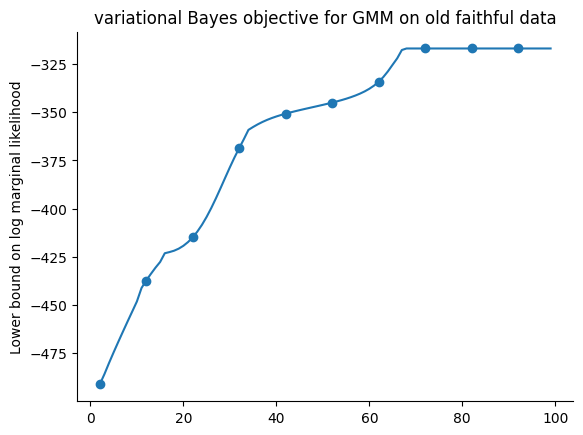

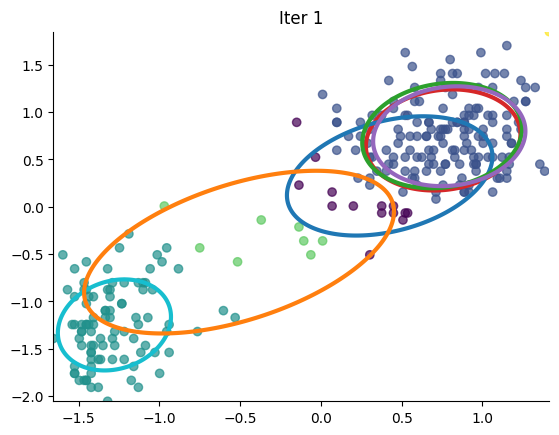

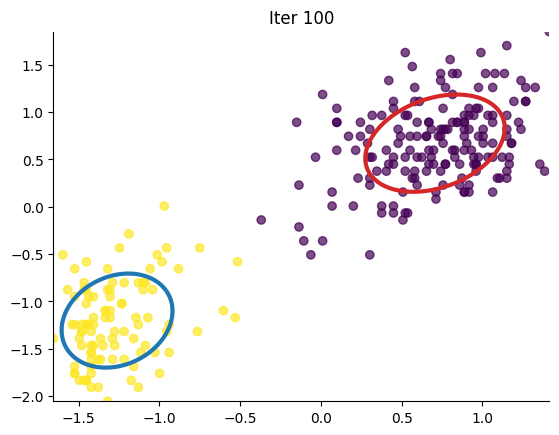

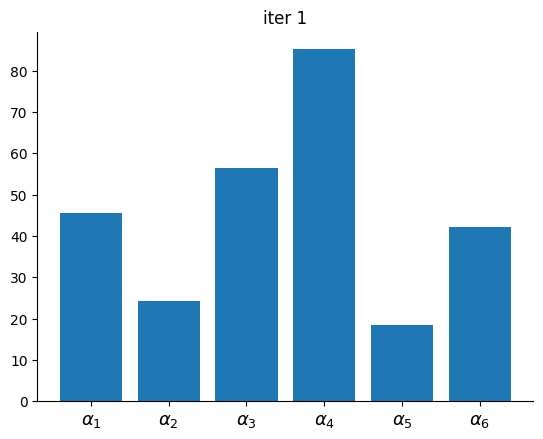

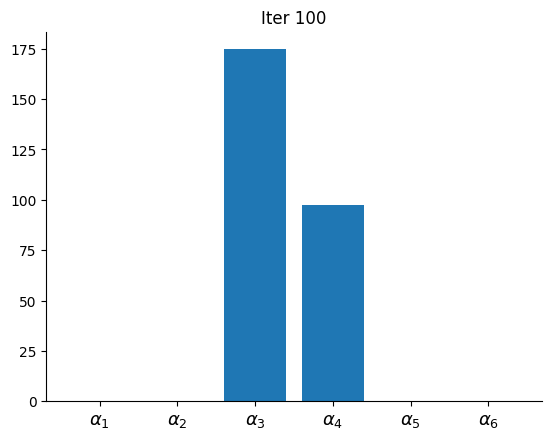

In [21]:
def plot_mixtures(X, r, mu, pi, Sigma, ax, step=0.01, cmap="viridis", levels=1):
    colors = ["tab:red", "tab:blue", "tab:green", "tab:cyan", "tab:orange", "tab:purple"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    Nk = r.sum(axis=0)

    # Plotting distributions whose effective number of
    # observations is at least 1
    Norms = [scistats.multivariate_normal(mean=mui, cov=Sigmai) for mui, Sigmai, N in zip(mu, Sigma, Nk) if N > 1]

    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        ax.contour(xx, yy, density, levels=levels, colors=color, linewidths=3)

    ax.scatter(*X.T, alpha=0.7, c=r.argmax(axis=1), cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)

if __name__ == "__main__":
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False

    # normalization of the data
    data = jnp.array(np.loadtxt(rawdata))
    X = (data - data.mean(axis=0)) / data.std(axis=0)

    # Prior parameters
    key = random.PRNGKey(3141)
    N, M = X.shape
    # Here we define the no of gaussians using K
    K = 6
    # Creating the init mean
    m_0 = X.mean(axis=0, keepdims=True).T * jnp.ones((M, K))
    m_0 = m_0 + random.normal(key, (M, K))
    # 
    beta_0 = jnp.ones(K)
    alpha_0 = jnp.ones(K) * 0.001
    eta_0 = 4 * jnp.ones(K)

    W_0 = jnp.eye(M)[None, ...] * jnp.ones((K, 1, 1)) / 5
    print("N,M",N,M)
    print(f'm_0,beta_0,alpha_0,eta_0,W_0 : \n{m_0}, \n{beta_0}, \n{alpha_0}, \n{eta_0}, \n{W_0}')

    vbmixture = VBMixture()
    n_iterations = 100
    hist = vbmixture.fit(X, m_0, W_0, beta_0, alpha_0, eta_0, n_iterations, store_hist=True)
    iterations_range = np.arange(n_iterations)

    fig, ax = plt.subplots()
    ax.plot(iterations_range[2:], vbmixture.lower_bound_hist[2:])
    ax.scatter(iterations_range[2::10], vbmixture.lower_bound_hist[2::10])
    ax.set_title("variational Bayes objective for GMM on old faithful data")
    ax.set_ylabel("Lower bound on log marginal likelihood")
    # pml.savefig("gmmvb-lower-bound.pdf")

    fig, ax = plt.subplots()
    it1 = hist[1]
    pi_k, mu_k, Sigma_k = vbmixture.expected_values(it1)
    r_nk = vbmixture.compute_responsibilities(X, it1["alpha"], it1["beta"], it1["eta"], it1["m"], it1["W"])
    plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k, ax, levels=1)
    ax.set_title(f"Iter 1")
    # pml.savefig("gmmvb-cluster-it-1.pdf")

    fig, ax = plt.subplots()
    pi_k, mu_k, Sigma_k = vbmixture.expected_values()
    plot_mixtures(X, vbmixture.r_nk, mu_k, pi_k, Sigma_k, ax, levels=1)
    ax.set_title(f"Iter {n_iterations}")
    # pml.savefig(f"gmmvb-cluster-it-{n_iterations}.pdf")

    fig, ax = plt.subplots()
    ax.bar(np.arange(K), it1["alpha"])
    ax.set_xticks(range(K))
    ax.set_xticklabels([r"$\alpha_" f"{k+1}$" for k in range(K)], fontsize=13)
    ax.set_title("iter 1")
    # pml.savefig("gmmvb-alpha-dist-1.pdf")

    fig, ax = plt.subplots()
    ax.bar(np.arange(K), vbmixture.alpha_k)
    ax.set_xticks(range(K))
    ax.set_xticklabels([r"$\alpha_" f"{k+1}$" for k in range(K)], fontsize=13)
    ax.set_title("Iter 100")
    # pml.savefig(f"gmmvb-alpha-dist-{n_iterations}.pdf")

    plt.show()

In [29]:
jnp.eye(M)

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [30]:
jnp.eye(M)[None, ...]

Array([[[1., 0.],
        [0., 1.]]], dtype=float32)

In [31]:
jnp.ones((K, 1, 1)) / 5


Array([[[0.2]],

       [[0.2]],

       [[0.2]],

       [[0.2]],

       [[0.2]],

       [[0.2]]], dtype=float32)